### Plot main results:  
    - heatmap of information as function of model parameters (horiz/ama weight vs center/surround weight)  
    - where ganglion cells map onto this heatmap
    - cumulative information of full model, horizontal, amacrine only models, ganglion cell, ideal filter, center vs frequency
    - total information vs SNR

In [66]:
import numpy as np
import collections
from functools import partial

from surround.image_processing import *
from surround.data_handling import *
from aesthetics.plotting import *
from surround.modeling import difference_of_gaussians

from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

### Cells

In [5]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells()
cells['bipolar'] = load_bipolar_cells()
cells['amacrine'] = load_amacrine_cells()
cells['horizontal'] = load_horizontal_cells()

Verify that spacings for all cells is the same

In [12]:
spacings = []
for c in cells.keys():
    print(c)
    for space, rf in cells[c]:
        spacings.append(space)
samplerates = [float('%0.6f' %np.mean(np.diff(s))) for s in spacings]
print(np.unique(samplerates))

horizontal
amacrine
bipolar
ganglion
[ 0.444444  0.546835]


There are 2 different types of spacing. Let's take the average.

In [24]:
average_spacing = np.mean(np.stack([s for s in spacings if len(s)==80]), axis=0)
average_spacing -= np.min(abs(average_spacing)) # sample the peak at 0
average_spacing.shape

(80,)

In [26]:
np.mean(np.diff(average_spacing))

0.54683544303797449

Interpolate all of the receptive fields to be at the same spacing

In [30]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for space, rf in cells[c]:
        this_cell_interp = interp1d(space, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(average_spacing))

Plot them as a sanity check

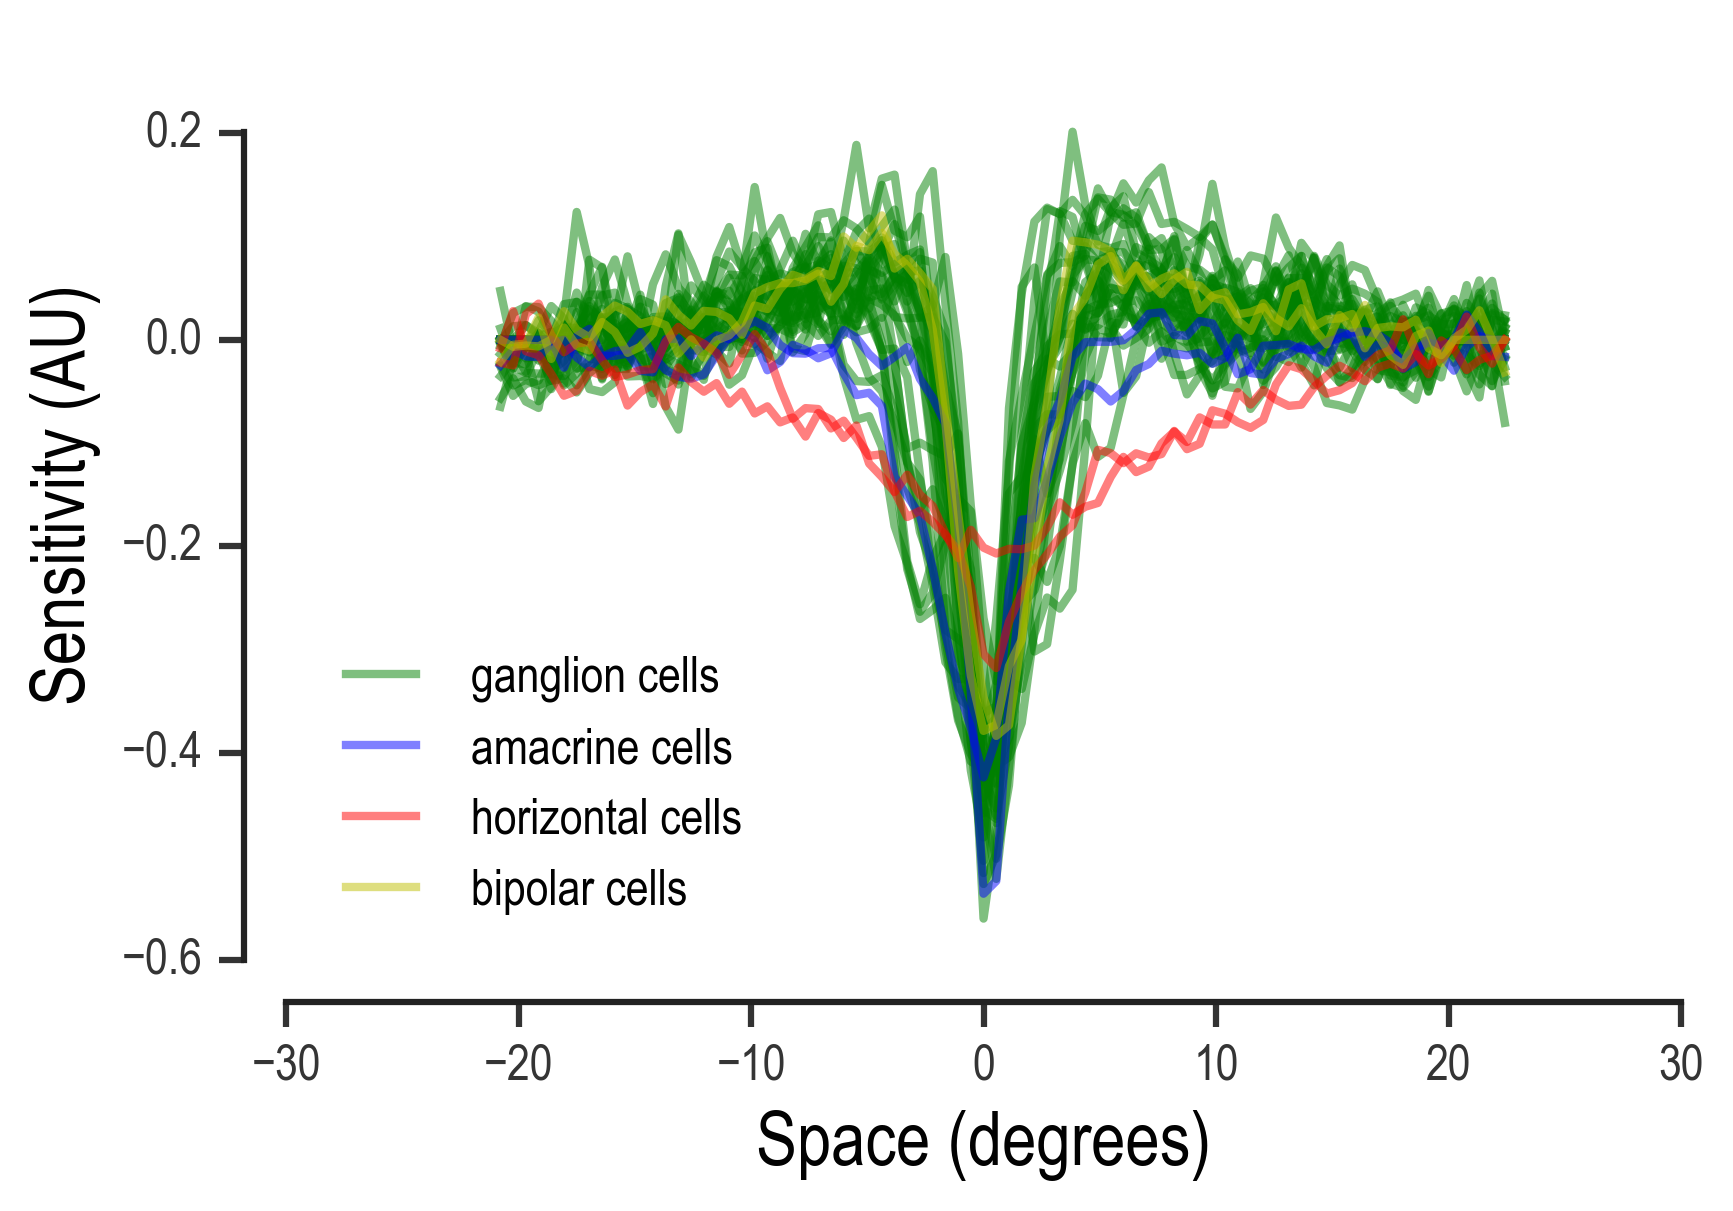

In [41]:
colorscheme = 'gbry'
for idc, c in enumerate(receptive_fields.keys()):
    this_color = colorscheme[idc]
    for idrf, rf in enumerate(receptive_fields[c]):
        if idrf == 0:
            plt.plot(average_spacing, rf, color=this_color, linewidth=2, alpha=0.5, label='%s cells' %c)
        else:
            plt.plot(average_spacing, rf, color=this_color, linewidth=2, alpha=0.5)

plt.ylabel('Sensitivity (AU)', fontsize=18)
plt.xlabel('Space (degrees)', fontsize=18)
plt.legend(frameon=False, loc='lower left', fontsize=12)
adjust_spines(plt.gca())

### Signal

Get the frequency range for average_spacing

In [51]:
freqs = np.linspace(0, 0.5/np.mean(np.diff(average_spacing)), len(np.fft.rfft(average_spacing)))

In [42]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd01A'
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 70 files in directory.


In [46]:
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches01A, spacing=spacing)

Interpolate signal at same resolution and scale as cell measurements

In [52]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt)
signal = func(freqs, *popt)

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


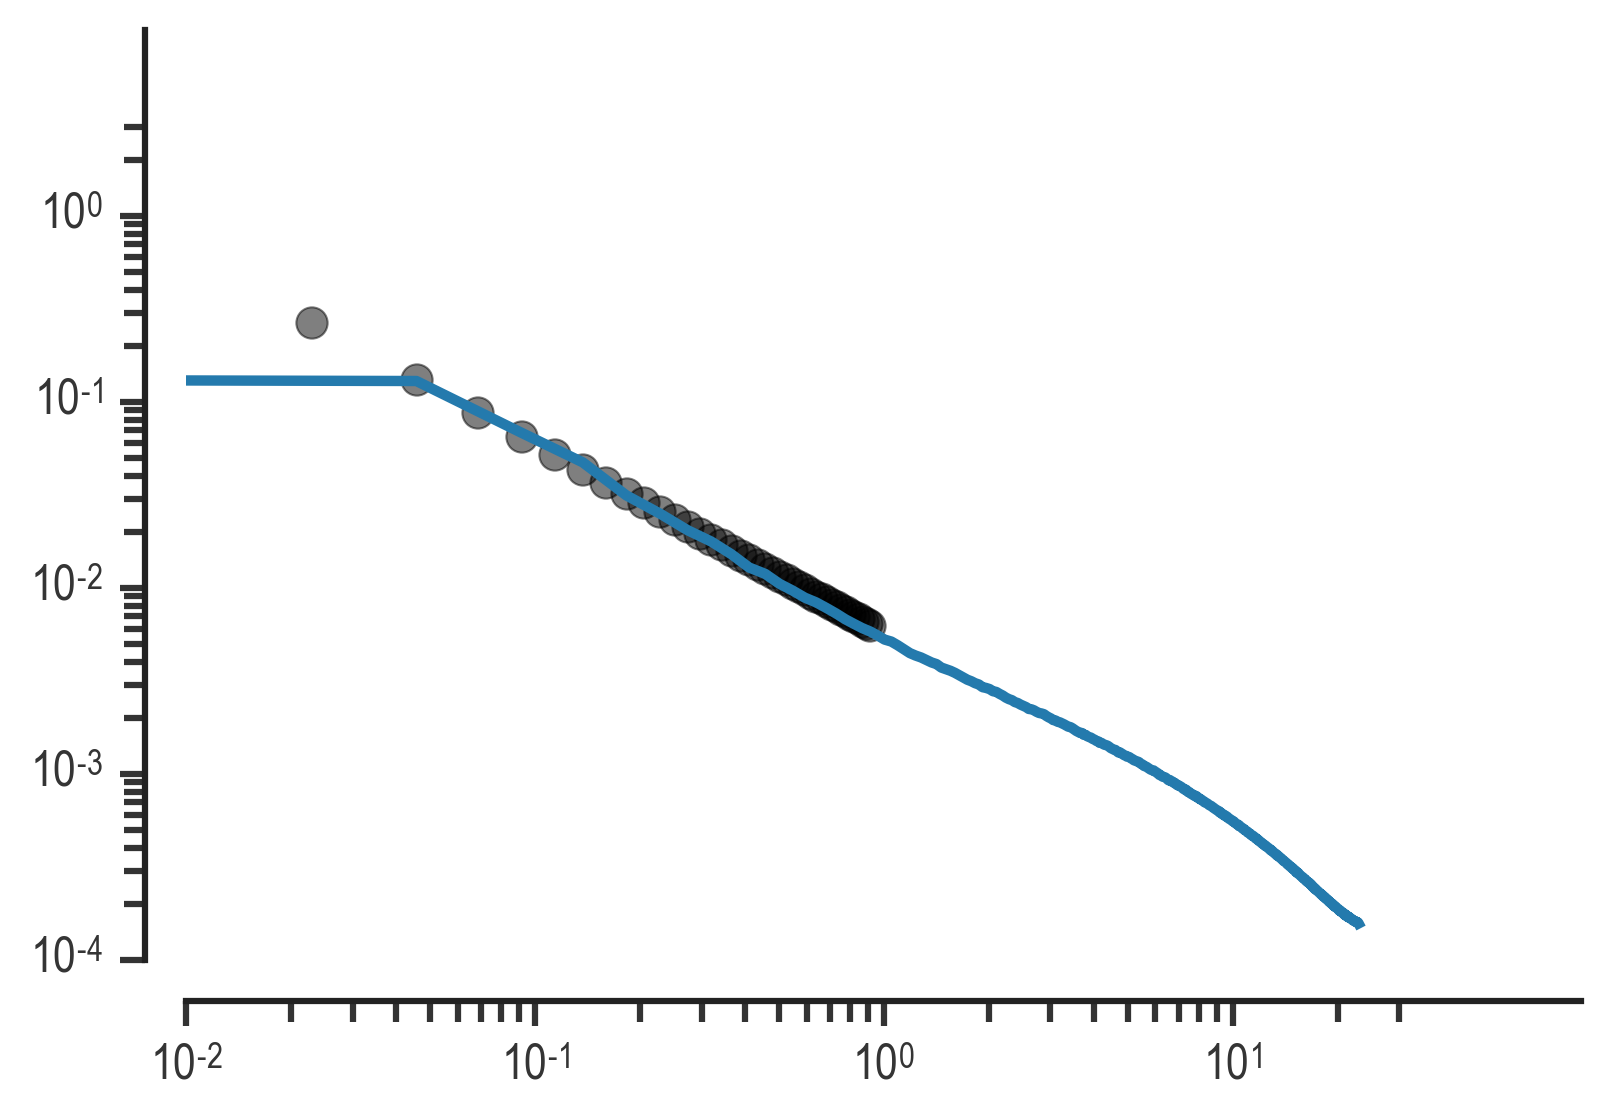

In [54]:
plt.plot(freqs, signal, 'k.', alpha=0.5)
plt.plot(signal_freqs, signal_amps)
plt.xscale('log')
plt.yscale('log')
adjust_spines(plt.gca())

In [55]:
spacing

0.021739130434782608

In [56]:
np.mean(np.diff(average_spacing))

0.54683544303797449

In [86]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0.)

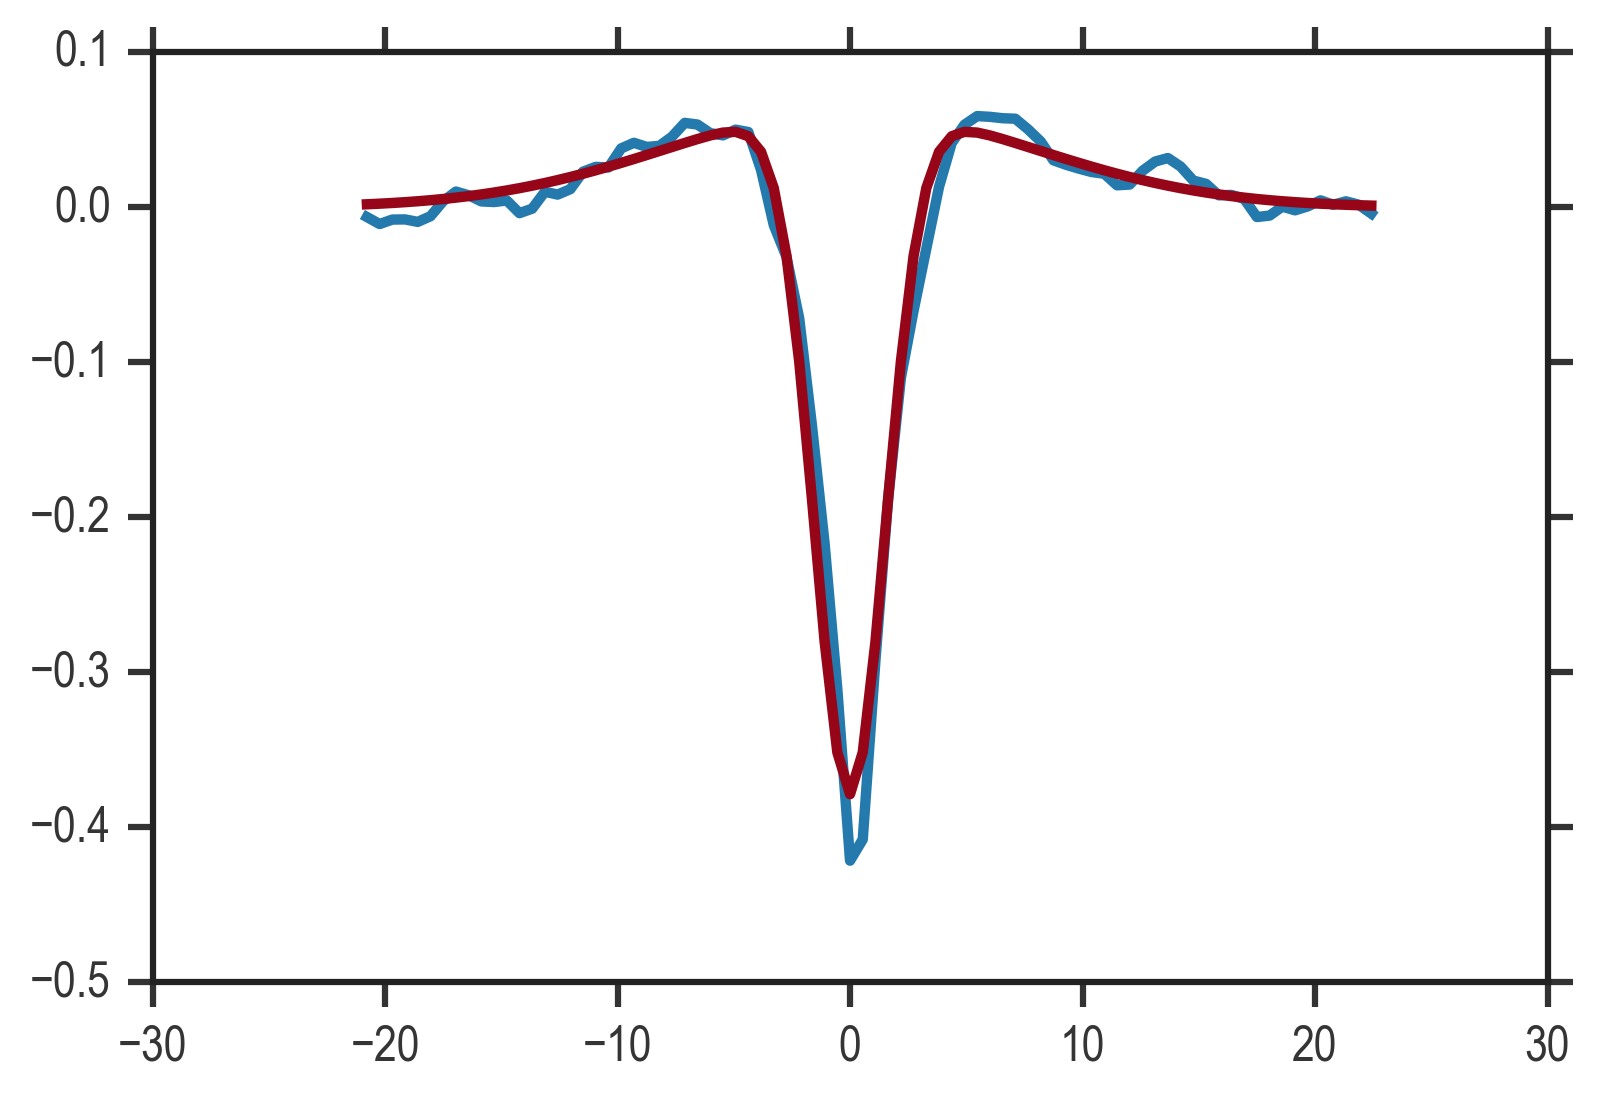

In [87]:
average_ganglion = np.mean(np.stack(receptive_fields['ganglion']), axis=0)
popt, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, average_ganglion)
plt.plot(average_spacing, average_ganglion)
plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt))

Couldn't fit cell 15
Couldn't fit cell 21
Couldn't fit cell 27


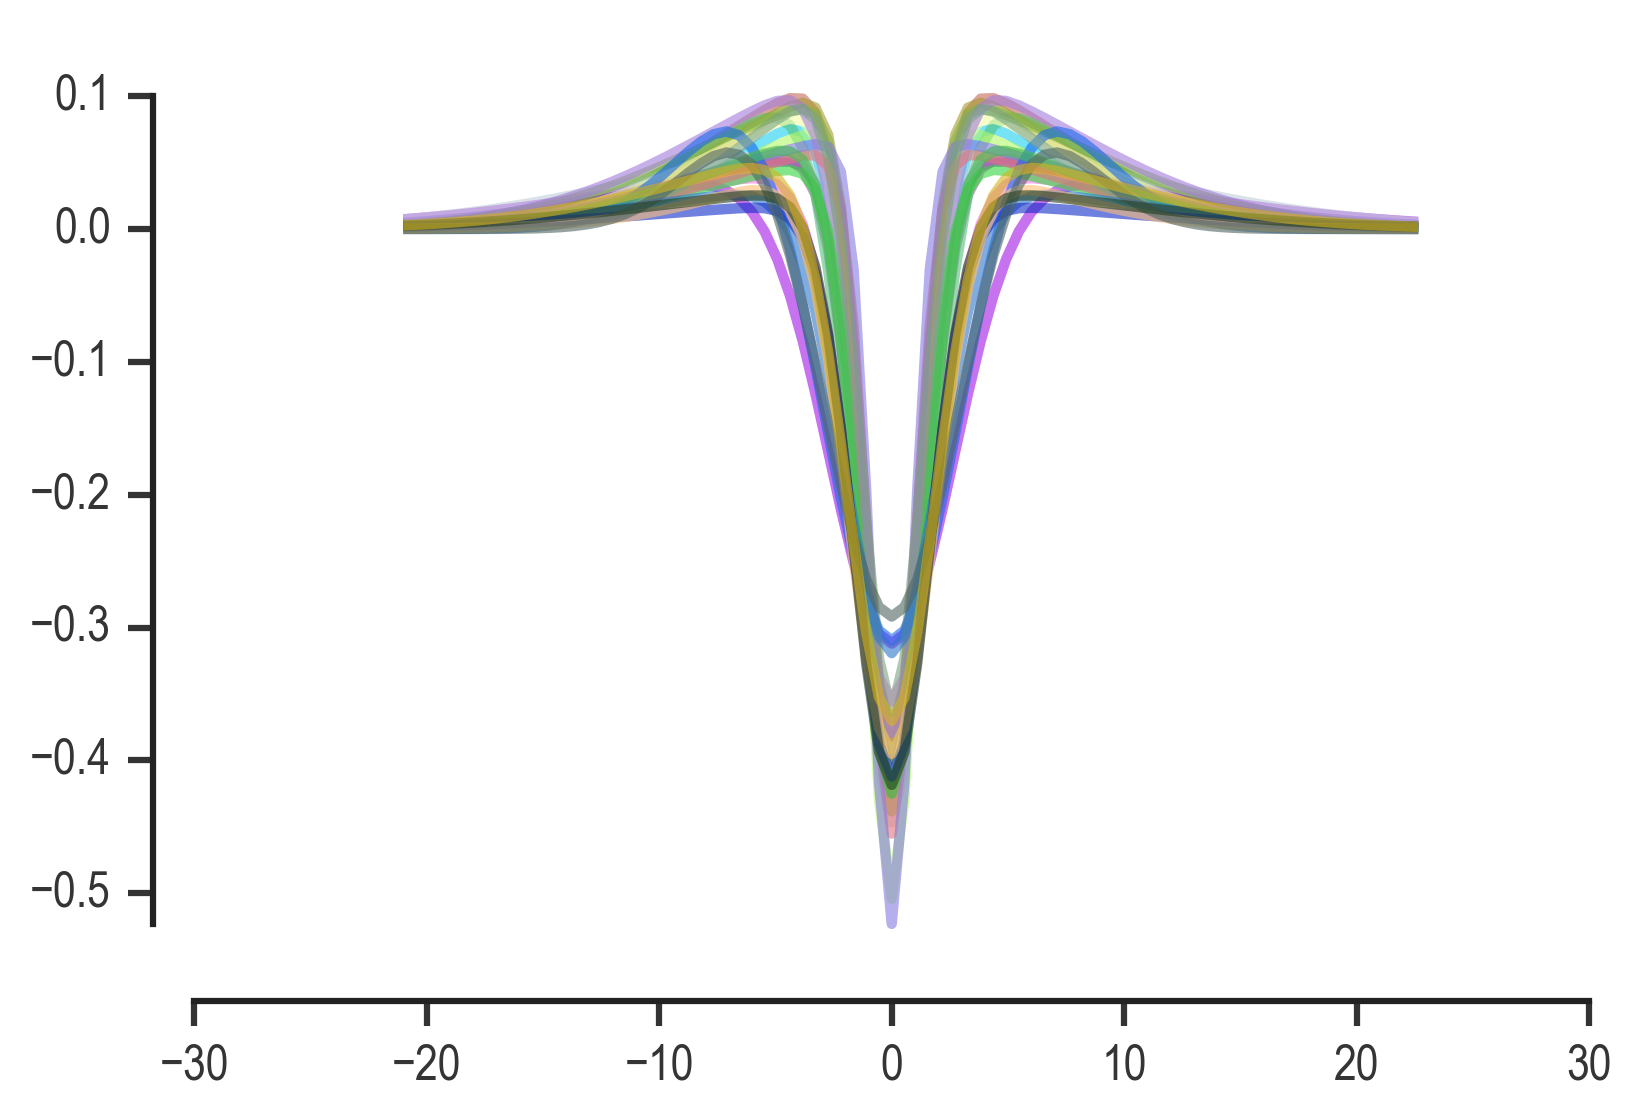

In [93]:
center_widths = []
surround_widths = []
for idg, g in enumerate(receptive_fields['ganglion']):
    try:
        popt_this, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, g, p0=popt)
        center_widths.append(np.min(abs(popt_this[:2])))
        surround_widths.append(np.max(abs(popt_this[:2])))
        plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt_this), color=np.random.rand(3), alpha=0.6)
    except:
        print("Couldn't fit cell %d" %idg)
        
plt.ylim(-.55, .15)
adjust_spines(plt.gca())

In [95]:
np.mean(surround_widths)

7.4899876868915491

In [96]:
np.mean(center_widths)

1.6329005789098545

In [101]:
tuple(np.random.choice(average_spacing, 2))

(1.6405063291139228, 19.139240506329109)

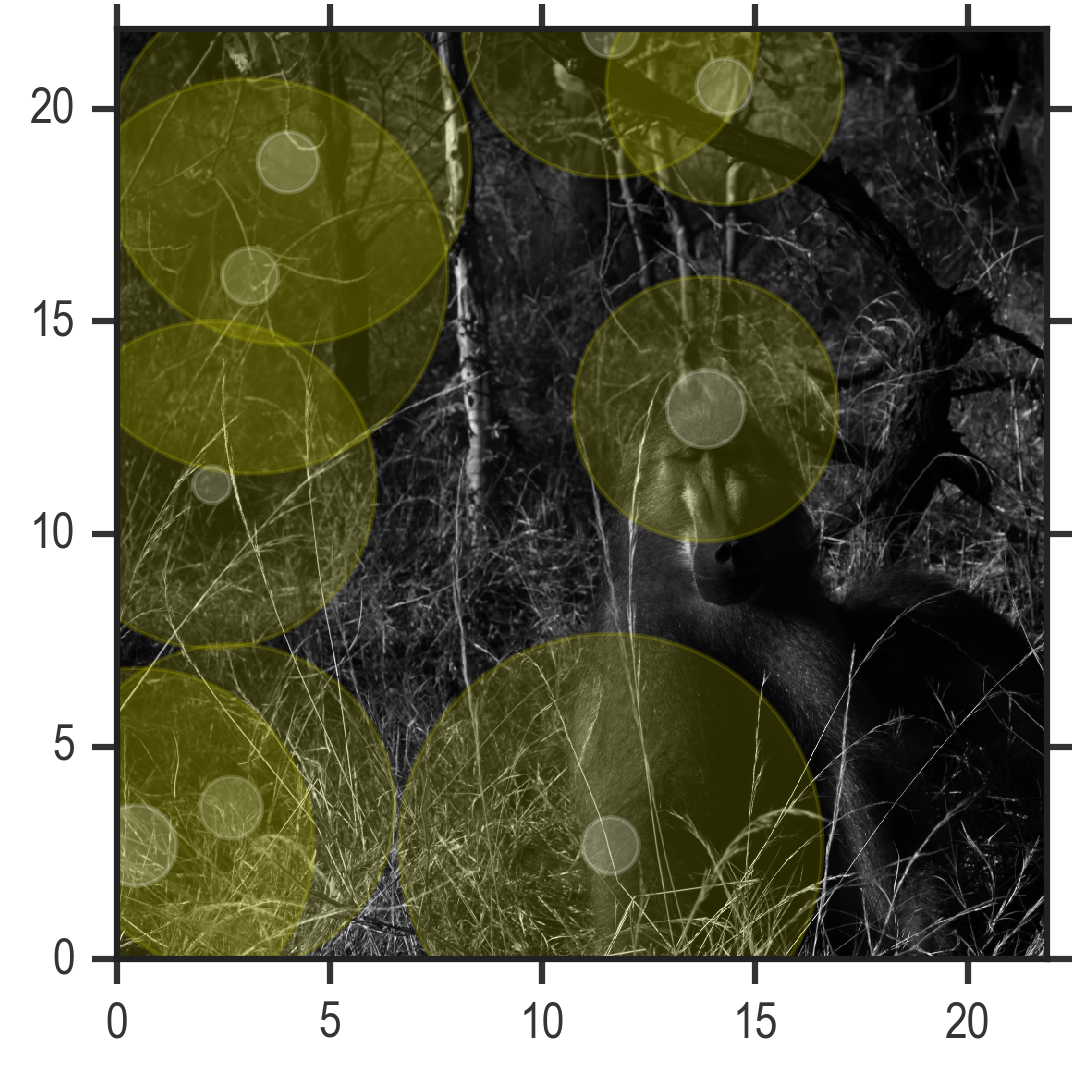

In [107]:
plt.imshow(patches01A[1], extent=[0,spacing*patches01A[1].shape[0],0,spacing*patches01A[1].shape[0]])
ax = plt.gca()

center_choices = np.linspace(0, spacing*patches01A[1].shape[0])
for idc, center_diameter in enumerate(center_widths):
    # select a subset
    if idc % 3 == 0:
        center = tuple(np.random.choice(center_choices, 2))
        circle_surround = plt.Circle(center, surround_widths[idc]/2, color='y', alpha=0.2)
        circle_center = plt.Circle(center, center_diameter/2, color='w', alpha=0.2)

        ax.add_artist(circle_surround)
        ax.add_artist(circle_center)

Salamanders have very low resolution eyes!